# Guidance Transformation class to normalize and schedule Classifier-free Guidance.

In [ ]:
#|default_exp guidance_tfm

The following classes implement:  

1. Baseline Classifier-free Guidance  
2. Scaling the prediction by the ratio of norms  
3. Scaling the `t - u` update by its norms  
4. Scaling both 2. + 3.

In [ ]:
#|export

'''Code for blog post:
    https://enzokro.dev/blog/posts/2022-11-15-guidance-expts-1
'''
import math
import torch

class GuidanceTfm:
    "Baseline Classifier-free Guidance for Difussion."
    name = "CFGuidance"
    def __init__(self, schedules, *args, **kwargs):
        self.schedules = schedules
        
    def encode(self, u, t, idx=None):
        "Applies guidance on `u` and `t` with optional pre/post processing."
        self.pre_proc(u, t, idx)
        self.guide(u, t, idx)
        self.post_proc(u, t, idx)
        return self.pred
    
    def guide(self, u, t, idx=None):
        "Mixes latents `u` and `t` based on guidance schedule for `g`."
        self.pred = u + (self.scheduler('g', idx) * (t - u))

    def pre_proc (self, u, t, idx=None): pass
    def post_proc(self, u, t, idx=None): pass
    
    def scheduler(self, name, idx):
        "Gets the scheduled value for parameter `name` at timestep `idx`."
        return self.schedules.get(name)[idx]
    
    
class BaseNormGuidance(GuidanceTfm):
    "Scales the noise prediction by its overall norm."
    name = "BaseNormGuidance"
    def post_proc(self, u, t, idx=None):
        self.pred = self.pred * (torch.linalg.norm(u) / torch.linalg.norm(self.pred))
        
        
class TNormGuidance(GuidanceTfm):
    "Scales the latent mix of `t - u`"
    name = "TNormGuidance"
    def guide(self, u, t, idx=None):
        self.pred = u + (self.scheduler('g', idx) * (t - u)) / torch.linalg.norm(t - u) * torch.linalg.norm(u)
        
        
class FullNormGuidance(TNormGuidance, BaseNormGuidance):
    "Applies both Base and T-Norm on the noise prediction."
    name = "FullNormGuidance"
    pass

The section below defines the cosine scheduler helpers.   

The bottom of the notebook has examples of creating schedules, and using them to initialize a `GuidanceTfm` class. 

In [ ]:
#|export

def get_cos_sched(num_steps: int = 50,
                  max_val: float = 7.5,
                  min_val: float = 0.15,
                  num_cycles: float = 0.5,
                  num_warmup_steps: int = 0,
                  warmup_init_val: float = 0.,
                  k_decay:float = 1.,
                  cycle_mul: float = 1.,
                  cycle_decay:float = 1.,
                  cycle_limit = 1.) -> list:
    '''Creates a cosine schedule based on the given parameters.
    
    Args:
        num_steps: Number of total steps in the schedules. 
        max_val: The maximum value in the schedule. 
        min_val: The minimum number in the schedule. 
        num_cycles: How many full cosine schedules to sweep. By default, 0.5.
        num_warmup_steps: Over how many steps to warmup.  
        cycle_mul: Param for timm scheduler.
        cycle_decay: Param for timm schedulers.
        cycle_limit: Param for timm schedulers.
        k_decay: Param for timm schedulers.  
        
    The cycle_* and k_decay `timm` parmeters are described in better detail here:
        https://timm.fast.ai/SGDR#CosineLRScheduler
    These args offer a lot of powerful flexibility in guiding the cosine scheduler.
        TODO: experiment with these settings for diffusion.  
        
    NOTE: cycle_* parameters might not work as intended, since we are dealing with "one" epoch.
        TODO: investigate
    
    Based on a combo of HuggingFace and timm schedulers:
        https://github.com/rwightman/pytorch-image-models/blob/main/timm/scheduler/cosine_lr.py
        https://github.com/huggingface/transformers/blob/v4.24.0/src/transformers/optimization.py#L104
    '''

    def cos_sched_helper(current_step):
        "Helper to compute cosine values."
        
        # get the warmup value
        if current_step < num_warmup_steps:
            init_offset = float(current_step * (max_val - warmup_init_val)) / float(max(1, num_warmup_steps))
            return warmup_init_val + init_offset
        
        # else get the regular scheduled values
        else:

            if cycle_mul != 1:
                i = math.floor(math.log(1 - current_step / num_steps * (1 - cycle_mul), cycle_mul))
                t_i = cycle_mul ** i * num_steps
                t_curr = current_step - (1 - cycle_mul ** i) / (1 - cycle_mul) * num_steps
            else:
                i = current_step // num_steps #
                t_i = num_steps
                t_curr = current_step - (num_steps * i)

            # find the scaled maximum value based on cycle_decay
            gamma = cycle_decay ** i
            scaled_max = max_val * gamma
            scaled_mag = 0.5 * (scaled_max - min_val)
            
            # find completion offset based on current step and k-decay
            t_curr = (t_curr - num_warmup_steps)
            t_i = max(1, num_steps - num_warmup_steps)
            scaled_progress = (t_curr ** k_decay) / (t_i ** k_decay)
            
            if i < cycle_limit:
                cos_val = (1 + math.cos(math.pi * 2 * num_cycles * scaled_progress))
                val = min_val + scaled_mag * cos_val
            else:
                val = min_val

            return val

    # get the actual schedule value
    vals = [cos_sched_helper(i) for i in range(num_steps)]
    return vals


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# creating a few cosine schedules

# parameters from the blog post
max_val = 7.5
min_val = 0.15
num_steps = 50
num_warmup_steps = 5


# baseline cosine schedule
cos_params = {
    'max_val':           max_val,
    'num_steps':         num_steps,
    'min_val':           min_val,
    'num_warmup_steps':  0,
}

# cosine schedule with warmup 
warmup_cos_params = {
    'max_val':           max_val,
    'num_steps':         num_steps,
    'min_val':           min_val,
    'warmup_init_val':   min_val + 1., # to show we can offset the warmup relative to min
    'num_warmup_steps':  num_warmup_steps,
}

# cosine schedule with small values for T-Norm guidance
t_scale_params = {
    'max_val':         0.25,
    'num_steps':       num_steps,
    'min_val':         0.05,
}

# create the schedules
cos_g = get_cos_sched(**cos_params)
warmup_g = get_cos_sched(**warmup_cos_params)
TNorm_g = get_cos_sched(**t_scale_params)

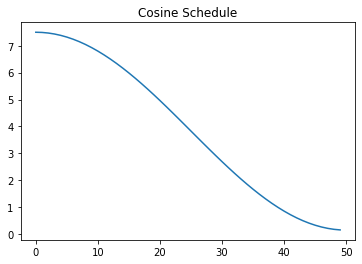

In [ ]:
# plot them 
plt.plot(cos_g)
plt.title('Cosine Schedule');

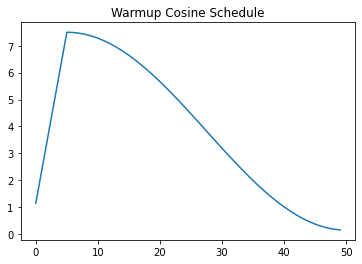

In [ ]:
plt.plot(warmup_g)
plt.title('Warmup Cosine Schedule');

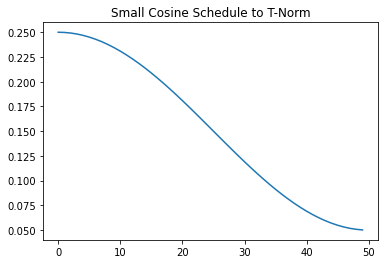

In [ ]:
plt.plot(TNorm_g)
plt.title('Small Cosine Schedule to T-Norm');

Next, we create a few Guidance Transformations:  

In [ ]:
# create a CFG with cosine schedule, but no normalization
sample_sched = {'g': cos_g}
tfm = GuidanceTfm(sample_sched)

# CFG with cosine schedule and BaseNorm
norm_tfm = BaseNormGuidance(sample_sched)

# creating a TNorm guidance with the smaller schedule
small_sched = {'g': TNorm_g}
small_tfm = TNormGuidance(small_sched)